# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D. 

## PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo cameras provide  us  with  a  convenient  way  to  generate  dense  point  clouds. Dense here,  in  contrast  to sparse, means all the image points are used for the reconstruction.  In this part of the assignment you will be generating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Note that the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the provided ground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [1]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


**Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).**

We have created disparity map for each left-right stereo image pair. Disparity map measures the difference in apparent positions of the same point as observed in the left and right stereo image pair. This can be related to the depth of that point (closer objects have a higher disparity). We got the disparity map using OpenCV's StereoSGBM function. It uses Semi-Global Block Matching to calculate corresponding points and then measures the differences in their apparent positions.

Next, we calculate the reverse projection matrix, which uses the dimensions of the image, the focal distance and the baseline, and along with the disparity (or depth) information, helps to reproject the image points back into the 3D world. OpenCV's reprojectImageTo3D comes in handy.

In [2]:
def reprojectImageTo3d(disparity,Q):
    points = []
    disparity_map = []
    for i in range(disparity.shape[0]):
        for j in range(disparity.shape[1]):
            disparity_map.append([j,i,disparity[i,j],1])
    for dis in disparity_map: points.append(np.dot(Q, dis))
    return np.array(points)

def find_disparity(imageL,imageR):
    stereo = cv2.StereoSGBM_create(minDisparity = -39,
        numDisparities = 144,
        disp12MaxDiff = 1,
        blockSize=5,
        P1= 8*3* 5**2,
        P2= 32*3*5**2,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32,
        preFilterCap= 63
        )
    disparity = stereo.compute(imageL, imageR).astype(np.float32)/64.0
    disparity = (disparity+39)/144
    return disparity

In [3]:
f = open('../data/poses.txt', 'r')
poses = np.loadtxt(f)
poses = poses.reshape(len(poses),3,4)
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
              [0.000000e+00, 7.070912e+02, 1.831104e+02],
              [0.000000e+00, 0.000000e+00, 1.000000e+00]])
f = K[0,0]
b = 0.53790448812
pcd = o3d.geometry.PointCloud()
combined_pcd = o3d.geometry.PointCloud()
[h, w] = [370, 1226] # Got from image shape
[m_start, m_end] = [-1500, 1500]
Q = np.array([[1, 0, 0, -w/2], [0, -1, 0, h/2], [0, 0, 0, f], [0, 0, 1/b, 0]])

for i in range(21):
    print (f"Running for 0000000{460+i}.png")
    imgL = cv2.imread("../data/img2/0000000"+str(460+i)+".png")
    imgR = cv2.imread("../data/img3/0000000"+str(460+i)+".png")
    disparity = find_disparity(imgL,imgR)
    point_cloud = reprojectImageTo3d(disparity,Q)
    colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    colors = colors[disparity >= disparity.min()]
    colors = colors/255
    cloud_colors = np.array(colors)
    point_cloud[:,0] /= point_cloud[:,3]
    point_cloud[:,1] /= point_cloud[:,3] 
    point_cloud[:,2] /= point_cloud[:,3]
    point_cloud[:,3] /= point_cloud[:,3]
    point_cloud = (poses[i] @ point_cloud.T).T
    mask = ((m_start <= point_cloud[:,1]) & (point_cloud[:,1] < m_end) &
        (m_start <= point_cloud[:,2]) & (point_cloud[:,2] < m_end) &
        (m_start <= point_cloud[:,0]) & (point_cloud[:,0] < m_end))
    point_cloud = point_cloud[mask]
    cloud_colors = cloud_colors[mask]
    point_cloud[:,0] *= -1
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(cloud_colors)
    combined_pcd = combined_pcd + pcd

o3d.io.write_point_cloud("colored_op.pcd", combined_pcd)

Running for 0000000460.png
Running for 0000000461.png
Running for 0000000462.png
Running for 0000000463.png
Running for 0000000464.png
Running for 0000000465.png
Running for 0000000466.png
Running for 0000000467.png
Running for 0000000468.png
Running for 0000000469.png
Running for 0000000470.png
Running for 0000000471.png
Running for 0000000472.png
Running for 0000000473.png
Running for 0000000474.png
Running for 0000000475.png
Running for 0000000476.png
Running for 0000000477.png
Running for 0000000478.png
Running for 0000000479.png
Running for 0000000480.png


True

In [4]:
output = o3d.io.read_point_cloud("colored_op.pcd")
o3d.visualization.draw_geometries([output])

## PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recover this pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since here you’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.


In [5]:
def AB(x, X):
    A = (np.vstack((x[:,0]*X[:,0],np.vstack((x[:,0]*X[:,1],np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3])))))))
    A = A.T
    B = (np.vstack((x[:,1]*X[:,0],np.vstack((x[:,1]*X[:,1],np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3])))))))
    B = B.T
    return A, B

def DLT(x,X):
    x[:,0] = x[:,0]/x[:,2]
    x[:,1] = x[:,1]/x[:,2]
    [A, B] = AB(x, X)
    M = np.vstack((np.hstack((-X,np.hstack((np.zeros(X.shape), A)))), np.hstack((np.zeros(X.shape), np.hstack((-X,B))))))
    U,D,VT = np.linalg.svd(M);
    P = np.array(VT[-1]).reshape(3,4);
    return P/P[-1,-1]

def Jacobian(x,X):
    X[:,0] = X[:,0]/x[:,2]
    X[:,1] = X[:,1]/x[:,2]
    X[:,2] = X[:,2]/x[:,2]
    X[:,3] = X[:,3]/x[:,2]
    x[:,0] = x[:,0]/x[:,2]
    x[:,1] = x[:,1]/x[:,2]
    [A, B] = AB(x, X)
    J = np.vstack((np.hstack((-X,np.hstack((np.zeros(X.shape),A)))), np.hstack((np.zeros(X.shape),np.hstack((-X,B))))))
    return J

def GaussNewton(P,x_gt,X,N,tol): 
    errors = []
    for i in range(N):
        x = np.dot(P, X.T)
        x = x.T
        A = x_gt[:,0]/x_gt[:,2] - x[:,0]/x[:,2]
        B = x_gt[:,1]/x_gt[:,2] - x[:,1]/x[:,2]
        J = Jacobian(x,X)
        R = (np.hstack((A,B))).reshape(-1,1)
        P = (P.reshape(12,1) - np.dot(np.dot(np.linalg.pinv(np.dot(J.T, J)), J.T), R)).reshape(3,4)
        errors.append((R.T@R/2/len(X)).item(0))
        if (i%2==0): print(f"ITERATION {i+1}    COST {errors[i]}")
        if(np.linalg.norm(np.dot(np.dot(np.linalg.inv(np.dot(J.T, J)), J.T), R))<tol): break
    return P, errors

In [6]:
pcd_pts = np.asarray(output.points)
homo_points = np.hstack((pcd_pts,np.ones((pcd_pts.shape[0],1))))
homo_points = homo_points[0::10,:] # Downsample 10 times

T = np.eye(4,4)
T[:3,:4] = poses[0]
T = np.linalg.inv(T)
P_gt = K @ T[:3,:4]
print(" Projection matrix ground truth:\n", P_gt)

homo_img = (P_gt@ homo_points.T) # Image in 0th camera's frame 
homo_img = homo_img.T
P_init = DLT(homo_img[:10,:], homo_points[:10,:])
print("\n Projection matrix initialisation using DLT:\n", P_gt[-1,-1]*P_init)

 Projection matrix ground truth:
 [[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

 Projection matrix initialisation using DLT:
 [[-8.90929374e+02  5.38382431e+01 -2.56110052e+02 -1.53083393e+05]
 [-3.68164374e+01  7.13414870e+02 -1.52284349e+02  1.99945050e+01]
 [-4.11338117e-01  4.10739699e-02 -9.10556864e-01 -2.77880277e+01]]


ITERATION 1    COST 10721872042.9874
ITERATION 3    COST 630.4918646864929
ITERATION 5    COST 1.2323980106384176
ITERATION 7    COST 1.232398092366497
ITERATION 9    COST 1.2323979979771944
ITERATION 11    COST 1.232398005149705
ITERATION 13    COST 1.232398015669025
ITERATION 15    COST 1.2323980044549387
ITERATION 17    COST 1.2323979957456557
ITERATION 19    COST 1.2323979972146046
ITERATION 21    COST 1.2323980507589138
ITERATION 23    COST 1.2323980395955654
ITERATION 25    COST 1.2323980239746999
ITERATION 27    COST 1.2323980271316712
ITERATION 29    COST 1.2323980419920975
ITERATION 31    COST 1.2323979969850405
ITERATION 33    COST 1.2323980189504329
ITERATION 35    COST 1.2323979975079242
ITERATION 37    COST 1.2323980019649365
ITERATION 39    COST 1.232398101246266

Took 40 iterations

Optimized projection matrix:
[[-8.90929375e+02  5.38382431e+01 -2.56110052e+02 -1.53083393e+05]
 [-3.68164374e+01  7.13414870e+02 -1.52284349e+02  1.99945050e+01]
 [-4.11338167e-01  4.1074095

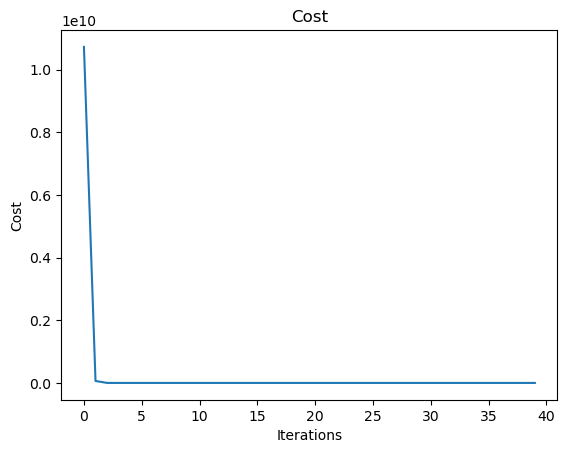

In [7]:
P_op, Cost = GaussNewton(P_init, homo_img, homo_points, 40,1e-4)
P_op = P_gt[-1,-1]*(P_op/P_op[-1,-1]) 

print(f"\nTook {len(Cost)} iterations")
print("\nOptimized projection matrix:")
print(P_op)

plt.clf()
plt.plot(Cost)
plt.title('Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

**Make sure that you write about how you calculate the residual and jacobians.**  

The shape of the residual matrix is `[2 * Number of points, 1]`. For i<sup>th</sup> point, the row number 2 * i - 1 is the difference in x-coordinate after reprojection from 3D point and row number 2 * i is the difference in y-coordinate after reprojection from 3D point.   
The shape of the residual matrix is `[2 * Number of points, 12]`. Number of rows is same as number of rows in residual and 12 columns are due to the 12 unknowns of P. Each column entry for a row is the partial differentiation of the residual w.r.t one of the 12 elements of P.

## PART 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

#### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.

In [8]:
img1_pts = np.array([[810.15633291, 198.58590281],
 [876.07031141, 202.01000559],
 [820.42864125, 183.1774403 ],
 [873.50223432, 185.74551739],
 [798.17197319, 218.27449379],
 [855.52569474, 224.26667365],
 [382.99951124, 271.34808686],
 [388.9916911,  178.89731183],
 [263.15591398,  65.04589443],
 [456.61772099,  50.49345762],
 [353.03861193,  36.7970465 ],
 [354.75066332,  55.62961179],
 [287.98065913, 295.31680631],
 [204.09014104, 309.86924312]])

img2_pts = np.array([[ 965.95300936,  213.13833962],
 [1054.12365591,  218.27449379],
 [ 979.64942047,  196.01782572],
 [1048.98750175,  197.72987711],
 [ 953.96864963,  236.25103338],
 [1031.01096216,  243.09923893],
 [ 479.73041475,  281.6203952 ],
 [ 487.434646,    181.46538891],
 [ 371.01515152,   65.04589443],
 [ 561.90888144,   47.06935484],
 [ 458.32977238,   34.22896942],
 [ 458.32977238,   51.34948331],
 [ 377.86335707,  307.30116604],
 [ 288.83668482,  320.99757715]]
)

img1_pts = img1_pts.round(0)
img2_pts = img2_pts.round(0)
img1_pts = img1_pts.astype(int)
img2_pts = img2_pts.astype(int)

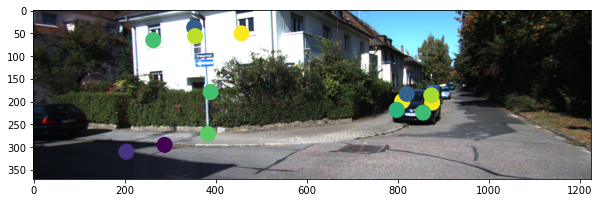

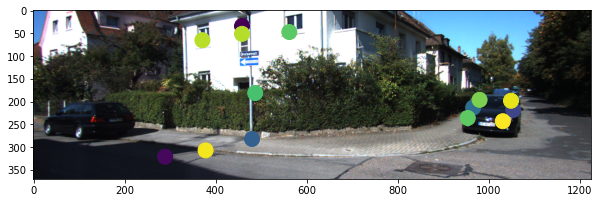

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np

image_points = img1_pts
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))
img = mpimg.imread('../data/img2/0000000460.png')
imgplot = plt.imshow(img)
colors = np.random.rand(N)
area = (15 * np.ones(N))**2 
plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

image_points = img2_pts
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))
img=mpimg.imread('../data/img2/0000000463.png')
imgplot = plt.imshow(img)
colors = np.random.rand(N)
area = (15 * np.ones(N))**2 
plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

In [10]:
def _reprojectImageTo3d(disparity, Q, img_pts):
    points = []
    disparity_map = []
    for k in range(len(img_pts)):
        i = img_pts[k][1]
        j = img_pts[k][0]
        disparity_map.append([j,i,disparity[i,j],1])
    for dis in disparity_map: points.append(np.dot(Q, dis))
    return np.array(points)

imgL = cv2.imread("../data/img2/0000000460.png")
imgR = cv2.imread("../data/img3/0000000460.png")
disparity = find_disparity(imgL,imgR)
point_cloud = _reprojectImageTo3d(disparity,Q, img1_pts)
point_cloud[:,0] = point_cloud[:,0] / point_cloud[:,3]
point_cloud[:,1] = point_cloud[:,1] / point_cloud[:,3]
point_cloud[:,2] = point_cloud[:,2] / point_cloud[:,3]
point_cloud[:,3] = point_cloud[:,3] / point_cloud[:,3]
point_cloud1 = point_cloud.copy()

imgL = cv2.imread("../data/img2/0000000463.png")
imgR = cv2.imread("../data/img3/0000000463.png")
disparity = find_disparity(imgL,imgR)
point_cloud = _reprojectImageTo3d(disparity,Q, img2_pts)
point_cloud[:,0] = point_cloud[:,0] / point_cloud[:,3]
point_cloud[:,1] = point_cloud[:,1] / point_cloud[:,3]
point_cloud[:,2] = point_cloud[:,2] / point_cloud[:,3]
point_cloud[:,3] = point_cloud[:,3] / point_cloud[:,3]
point_cloud2 = point_cloud.copy()

print("3D Points from 0000000460.png")
print(point_cloud1)
print("\n3D Points from 0000000463.png")
print(point_cloud2)

3D Points from 0000000460.png
[[ 3.37571216e+02 -2.39898326e+01  1.21164282e+03  1.00000000e+00]
 [ 4.47418404e+02 -2.89205812e+01  1.20291109e+03  1.00000000e+00]
 [ 3.56307933e+02  3.44258872e+00  1.21711210e+03  1.00000000e+00]
 [ 4.46313395e+02 -1.71001301e+00  1.20913515e+03  1.00000000e+00]
 [ 3.13219128e+02 -5.58715202e+01  1.19715940e+03  1.00000000e+00]
 [ 4.11136756e+02 -6.59849115e+01  1.19634231e+03  1.00000000e+00]
 [-3.83126821e+02 -1.43256116e+02  1.17785045e+03  1.00000000e+00]
 [-3.72881609e+02  9.98790023e+00  1.17705939e+03  1.00000000e+00]
 [-6.23451196e+02  2.13754696e+02  1.25953387e+03  1.00000000e+00]
 [-2.74040809e+02  2.37150701e+02  1.24212721e+03  1.00000000e+00]
 [-4.59830597e+02  2.61749724e+02  1.25054680e+03  1.00000000e+00]
 [-4.56782339e+02  2.28391169e+02  1.25188671e+03  1.00000000e+00]
 [-5.27030282e+02 -1.78379480e+02  1.14664146e+03  1.00000000e+00]
 [-6.52783978e+02 -1.99506106e+02  1.12855209e+03  1.00000000e+00]]

3D Points from 0000000463.png


In [11]:
def Procrustes(X, P):
    n = X.shape[1]
    dim = X.shape[0]
    T = np.identity(4)
    error = np.sqrt(np.sum(np.square(X-P)) / X.shape[1])
    print('Initial error: '+str(error))
    for iteration in range(1):
        W = np.zeros((3,3))
        point_cloud1_mean = np.mean(X, axis = 1, keepdims = True)
        point_cloud2_mean = np.mean(P, axis = 1, keepdims = True)
        for idx in range(n):
            point1 = X[:, idx]
            point1 = point1.reshape(3,1)
            arr1 = point1 - point_cloud1_mean
            point2 = P[:, idx]
            point2 = point2.reshape(3,1)
            arr2 = point2 - point_cloud2_mean
            W = W+np.dot(arr1,arr2.T)
        W = W/n
        U, S, Vt = np.linalg.svd(W)
        R = np.dot(U,Vt)
        if np.linalg.det(R) < 0:
            Vt[dim - 1, :]*=-1
            R = U @ Vt
        t = point_cloud1_mean - np.dot( R , point_cloud2_mean)
        T_itr = R
        T_itr = np.append(T_itr, t, axis=1)
        T_itr = np.vstack([T_itr, [0, 0, 0, 1]])
        T = np.dot(T_itr, T)
        P = np.dot(R, P) + t
        error = np.sqrt(np.sum(np.square(X-P)) / X.shape[1])
    print(f"Error after alignment: {error}")
    return T

Running procrustes
Initial error: 220.1056442833469
Error after alignment: 49.50566071962197

Running PnP
ITERATION 1    COST 16994.07442957072
ITERATION 3    COST 3941.0219831978166
ITERATION 5    COST 38.61163696761118
ITERATION 7    COST 1.3966010181430037
ITERATION 9    COST 1.3966008336121725
ITERATION 11    COST 1.3966008336121563
ITERATION 13    COST 1.3966008336121625
ITERATION 15    COST 1.3966008336122082
Took 15 iterations


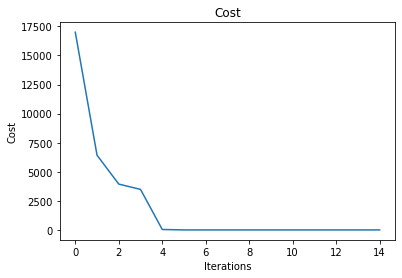


Optimized projection matrix:
[[ 6.46288880e+02 -9.71945461e+01  4.56181696e+02 -4.67835791e+02]
 [ 1.26102395e+01 -6.06861640e+02  1.62729797e+02 -1.27940879e+02]
 [ 1.22069850e-01 -1.98936991e-01  9.23015186e-01 -2.77880277e+01]]

Optimized transformation matrix:
[[ 8.10102838e-01  3.18814638e-02 -1.40532681e-01  2.29919778e+01]
 [-1.37775998e-02 -8.06733570e-01 -8.88694768e-03  7.01512902e+00]
 [ 1.22069850e-01 -1.98936991e-01  9.23015186e-01 -2.77880277e+01]]

Image points for frame 460:
[[810 199]
 [876 202]
 [820 183]
 [874 186]
 [798 218]
 [856 224]
 [383 271]
 [389 179]
 [263  65]
 [457  50]
 [353  37]
 [355  56]
 [288 295]
 [204 310]]

Image 2 points projected to 460's image plane::
[[808. 199.]
 [877. 202.]
 [821. 185.]
 [875. 186.]
 [796. 219.]
 [857. 223.]
 [385. 270.]
 [388. 179.]
 [264.  67.]
 [458.  51.]
 [353.  36.]
 [354.  54.]
 [289. 295.]
 [203. 311.]]

Image 1 points in 460's camera frame:
[[ 337.57121604  -23.98983261 1211.64282353]
 [ 447.41840386  -28.92058124 12

In [12]:
print("Running procrustes")
T = Procrustes(point_cloud1[:,:3].T, point_cloud2[:,:3].T)
P_init = K@T[:3,:]
point_cloud2_copy = point_cloud2.copy()
print("\nRunning PnP")
P_op, Cost = GaussNewton(P_init, np.vstack((img1_pts.T, np.ones(14))).T, point_cloud2_copy, 15, 1e-4)
P_op = P_gt[-1,-1]*(P_op/P_op[-1,-1]) 
T = np.linalg.inv(K)@P_op
print(f"Took {len(Cost)} iterations")
plt.clf()
plt.plot(Cost)
plt.title('Cost')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()
projected_img = (P_op@point_cloud2.T).T
projected_img[:,0] = projected_img[:,0]/projected_img[:,2]
projected_img[:,1] = projected_img[:,1]/projected_img[:,2]
projected_img[:,2] = projected_img[:,2]/projected_img[:,2]
print("\nOptimized projection matrix:")
print(P_op)
print("\nOptimized transformation matrix:")
print(T)
print("\nImage points for frame 460:")
print(img1_pts)
print("\nImage 2 points projected to 460's image plane::")
print(projected_img[:,:2].round(0))
X = point_cloud1[:,:3]
P1 = point_cloud2.T
P1 = np.dot(T, P1)
P1 = P1[:3]
P1[1,:] = -P1[1,:] 
print("\nImage 1 points in 460's camera frame:")
print(X)
print("\nFrame 463's points after transforming to 460's camera frame:")
print(P1.T)